In [1]:
import numpy as np
import pandas as pd
#pd.set_option('max_columns', None)
#pd.set_option('max_rows', 90)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler
from pycaret.regression import setup, compare_models

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

import optuna
from sklearn.linear_model import Ridge


In [2]:
from lightgbm import LGBMRegressor

In [3]:
from pycaret.regression import*

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('submission.csv')

In [5]:
target = train['SalePrice']
test_ids = test['Id']

train1 = train.drop(['Id', 'SalePrice'], axis=1)
test1 = test.drop('Id', axis=1)

data1 = pd.concat([train1, test1], axis=0).reset_index(drop=True)

In [6]:
data1

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [7]:
data1['MSSubClass'] = data1['MSSubClass'].astype(str)

In [8]:
list(set(data1.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('O')]

In [9]:
data1.select_dtypes(include = ['O']).columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [10]:
for column in data1.select_dtypes(include = ['O']).columns:
    data1[column] = data1[column].fillna("None")

# Impute using the column mode
for column in data1.select_dtypes(include = ['float64', 'int64']).columns:
    data1[column] = data1[column].fillna(data1[column].mean())

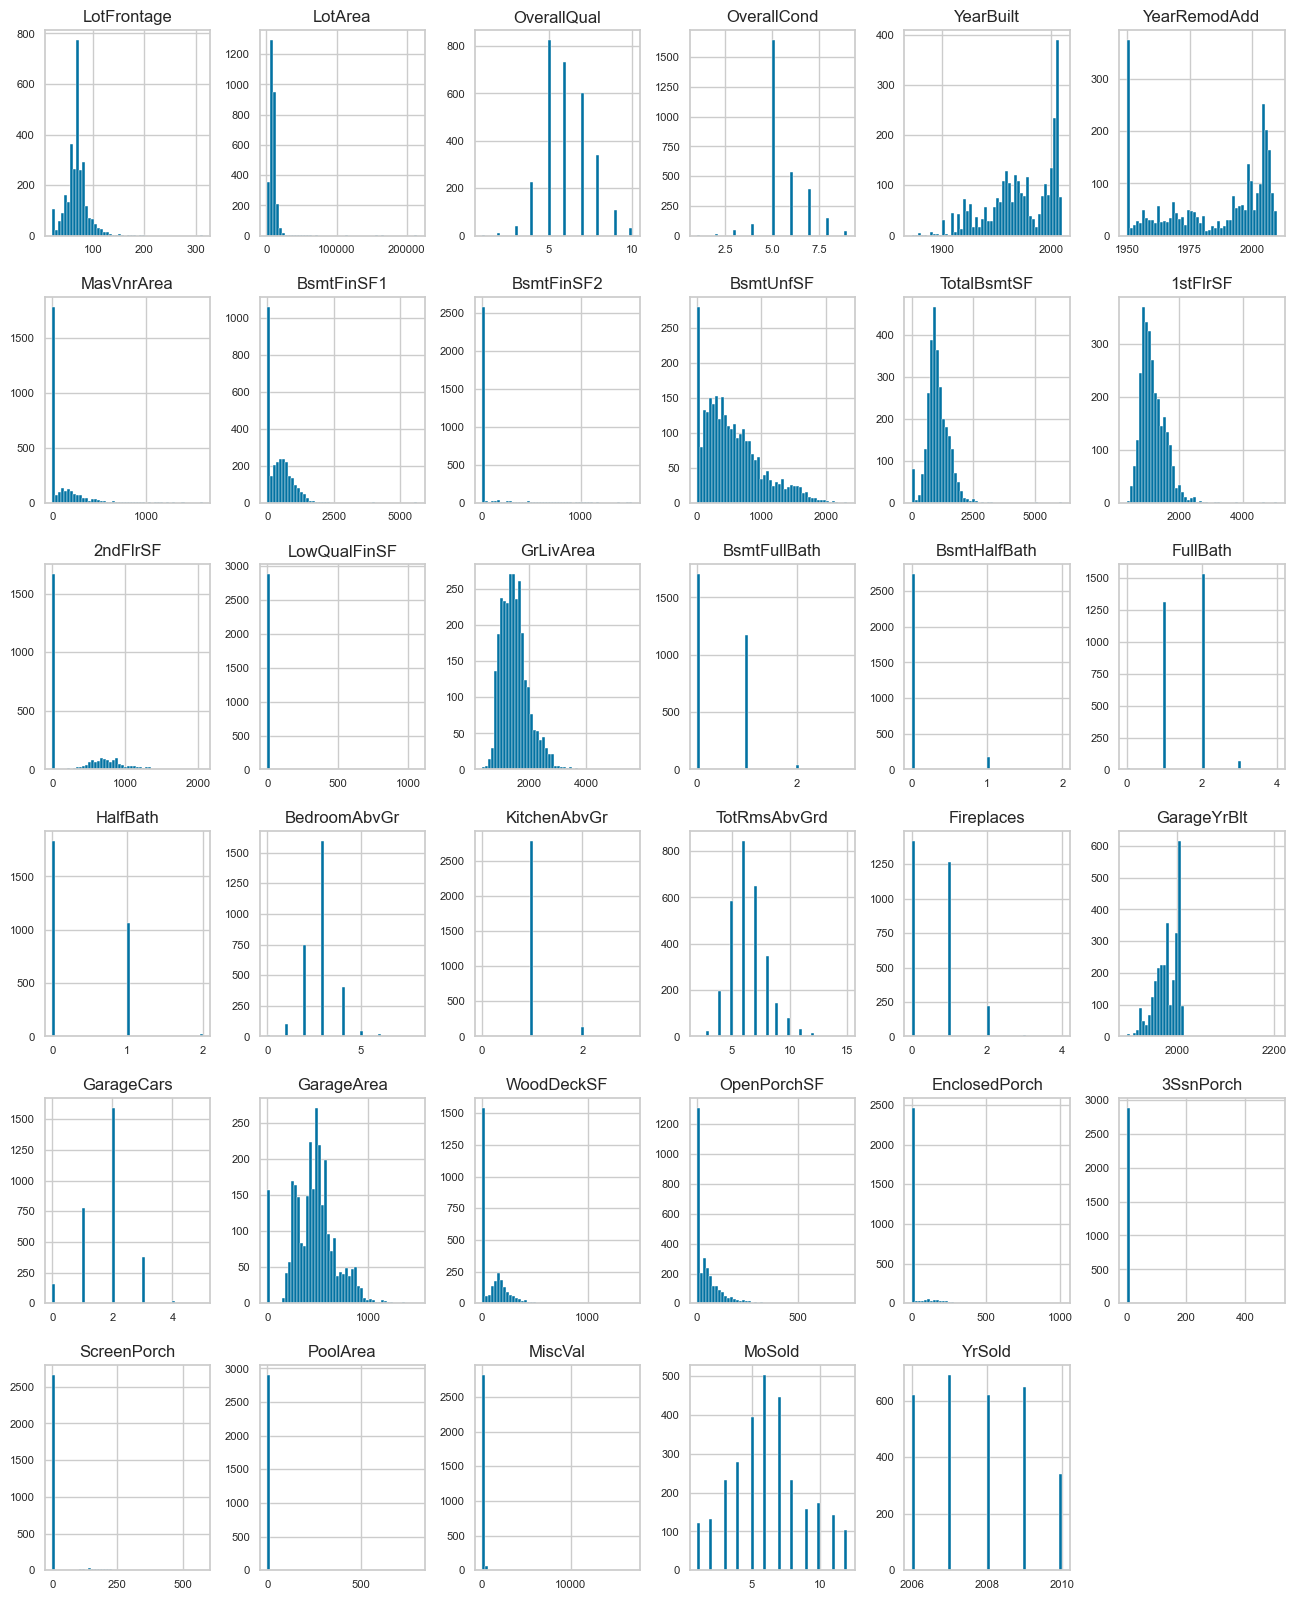

In [11]:
 data1.select_dtypes(include = ['float64', 'int64']).hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);


In [12]:
data2 = data1.copy()

In [13]:
data2["SqFtPerRoom"] = data2["GrLivArea"] / (data2["TotRmsAbvGrd"] +
                                                       data2["FullBath"] +
                                                       data2["HalfBath"] +
                                                       data2["KitchenAbvGr"])

data2['Total_Home_Quality'] = data2['OverallQual'] + data2['OverallCond']

data2['Total_Bathrooms'] = (data2['FullBath'] + (0.5 * data2['HalfBath']) +
                               data2['BsmtFullBath'] + (0.5 * data2['BsmtHalfBath']))

data2["HighQualSF"] = data2["1stFlrSF"] + data2["2ndFlrSF"]

In [14]:
skew_df = pd.DataFrame(data2.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data2[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,1.645574,1.645574,True
1,LotArea,12.822431,12.822431,True
2,OverallQual,0.197110,0.197110,False
3,OverallCond,0.570312,0.570312,True
4,YearBuilt,-0.599806,0.599806,True
5,YearRemodAdd,-0.451020,0.451020,False
6,MasVnrArea,2.611549,2.611549,True
7,BsmtFinSF1,1.425233,1.425233,True
8,BsmtFinSF2,4.146034,4.146034,True
9,BsmtUnfSF,0.919508,0.919508,True


In [15]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    data2[column] = np.log1p(data2[column])

In [16]:
data2['MoSold'] = (-np.cos(0.5236 * data2['MoSold']))

In [17]:
data3 = data2.copy()

In [18]:
data4 = data3

In [19]:
data4.select_dtypes(exclude = ['O'])

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF
0,4.189655,9.042040,7,1.791759,7.602900,2003,5.283204,6.561031,0.0,5.017280,...,0.0,0.0,0.0,0.000000,-0.499998,2008,4.966335,2.564949,3.5,7.444833
1,4.394449,9.169623,6,2.197225,7.589336,1976,0.000000,6.886532,0.0,5.652489,...,0.0,0.0,0.0,0.000000,0.866028,2007,4.950335,2.708050,2.5,7.141245
2,4.234107,9.328212,7,1.791759,7.601902,2002,5.093750,6.188264,0.0,6.075346,...,0.0,0.0,0.0,0.000000,-0.000011,2008,5.190732,2.564949,3.5,7.488294
3,4.110874,9.164401,7,1.791759,7.557995,1970,0.000000,5.379897,0.0,6.293419,...,0.0,0.0,0.0,0.000000,-0.499998,2006,5.256337,2.564949,2.0,7.448916
4,4.442651,9.565284,8,1.791759,7.601402,2000,5.860786,6.486161,0.0,6.196444,...,0.0,0.0,0.0,0.000000,-1.000000,2008,5.136251,2.639057,3.5,7.695758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,3.091042,7.568896,4,2.079442,7.586296,1970,0.000000,0.000000,0.0,6.304449,...,0.0,0.0,0.0,0.000000,1.000000,2006,4.923624,2.484907,1.5,6.996681
2915,3.091042,7.546974,4,1.791759,7.586296,1970,0.000000,5.533389,0.0,5.686975,...,0.0,0.0,0.0,0.000000,0.500004,2006,4.806750,2.302585,1.5,6.996681
2916,5.081404,9.903538,5,2.079442,7.581210,1996,0.000000,7.110696,0.0,0.000000,...,0.0,0.0,0.0,0.000000,-0.000011,2006,4.919981,2.564949,2.0,7.110696
2917,4.143135,9.253591,5,1.791759,7.597396,1992,0.000000,5.823046,0.0,6.356108,...,0.0,0.0,0.0,6.552508,0.866021,2006,4.806068,2.397895,1.5,6.878326


In [20]:
scaler = StandardScaler()
scaler.fit(data4.select_dtypes(exclude = ['O']))

data4[data4.select_dtypes(exclude = ['O']).columns] = pd.DataFrame(scaler.transform(data4.select_dtypes(exclude = ['O'])), index=data4.select_dtypes(exclude = ['O']).index, columns=data4.select_dtypes(exclude = ['O']).columns)
data4

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF
0,60,RL,-0.049717,-0.103719,Pave,None,Reg,Lvl,AllPub,Inside,...,None,-0.189329,-1.264774,0.157646,WD,Normal,-0.478766,0.250427,1.584176,0.573875
1,20,RL,0.588360,0.146544,Pave,None,Reg,Lvl,AllPub,FR2,...,None,-0.189329,0.785041,-0.602962,WD,Normal,-0.572066,1.212138,0.347782,-0.360482
2,60,RL,0.088781,0.457629,Pave,None,IR1,Lvl,AllPub,Inside,...,None,-0.189329,-0.514510,0.157646,WD,Normal,0.829720,0.250427,1.584176,0.707634
3,70,RL,-0.295173,0.136301,Pave,None,IR1,Lvl,AllPub,Corner,...,None,-0.189329,-1.264774,-1.363569,WD,Abnorml,1.212272,0.250427,-0.270414,0.586441
4,60,RL,0.738543,0.922662,Pave,None,IR1,Lvl,AllPub,FR2,...,None,-0.189329,-2.015061,0.157646,WD,Normal,0.512033,0.748470,1.584176,1.346150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,-3.472654,-2.993401,Pave,None,Reg,Lvl,AllPub,Inside,...,None,-0.189329,0.986074,-1.363569,WD,Normal,-0.727820,-0.287501,-0.888611,-0.805408
2915,160,RM,-3.472654,-3.036401,Pave,None,Reg,Lvl,AllPub,Inside,...,None,-0.189329,0.235797,-1.363569,WD,Abnorml,-1.409328,-1.512796,-0.888611,-0.805408
2916,20,RL,2.728701,1.586172,Pave,None,Reg,Lvl,AllPub,Inside,...,None,-0.189329,-0.514510,-1.363569,WD,Abnorml,-0.749062,0.250427,-0.270414,-0.454504
2917,85,RL,-0.194659,0.311255,Pave,None,Reg,Lvl,AllPub,Inside,...,Shed,5.094980,0.785030,-1.363569,WD,Normal,-1.413301,-0.872262,-0.888611,-1.169671


In [21]:
data7 = data4

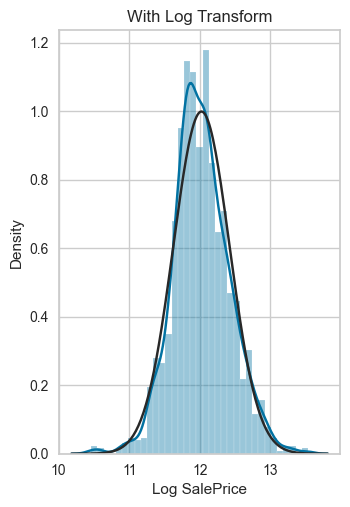

In [22]:
plt.subplot(1, 2, 2)
sns.distplot(np.log(target), kde=True, fit=scipy.stats.norm)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()

In [23]:
log_target = np.log(target)

In [24]:
train_f = data7.loc[:train.index.max(), :].copy()
test_f = data7.loc[train.index.max() + 1:, :].reset_index(drop=True).copy()

In [25]:
train_f

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF
0,60,RL,-0.049717,-0.103719,Pave,None,Reg,Lvl,AllPub,Inside,...,None,-0.189329,-1.264774,0.157646,WD,Normal,-0.478766,0.250427,1.584176,0.573875
1,20,RL,0.588360,0.146544,Pave,None,Reg,Lvl,AllPub,FR2,...,None,-0.189329,0.785041,-0.602962,WD,Normal,-0.572066,1.212138,0.347782,-0.360482
2,60,RL,0.088781,0.457629,Pave,None,IR1,Lvl,AllPub,Inside,...,None,-0.189329,-0.514510,0.157646,WD,Normal,0.829720,0.250427,1.584176,0.707634
3,70,RL,-0.295173,0.136301,Pave,None,IR1,Lvl,AllPub,Corner,...,None,-0.189329,-1.264774,-1.363569,WD,Abnorml,1.212272,0.250427,-0.270414,0.586441
4,60,RL,0.738543,0.922662,Pave,None,IR1,Lvl,AllPub,FR2,...,None,-0.189329,-2.015061,0.157646,WD,Normal,0.512033,0.748470,1.584176,1.346150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,-0.194659,-0.231508,Pave,None,Reg,Lvl,AllPub,Inside,...,None,-0.189329,0.235777,-0.602962,WD,Normal,-0.192242,-0.287501,0.347782,0.458413
1456,20,RL,0.774984,0.767440,Pave,None,Reg,Lvl,AllPub,Inside,...,None,-0.189329,-1.264774,1.678860,WD,Normal,1.694168,0.250427,0.965979,1.166031
1457,70,RL,-0.002863,0.029092,Pave,None,Reg,Lvl,AllPub,Inside,...,Shed,6.120742,0.785041,1.678860,WD,Normal,1.339258,2.053298,-0.270414,1.538740
1458,20,RL,0.088781,0.170303,Pave,None,Reg,Lvl,AllPub,Inside,...,None,-0.189329,0.235797,1.678860,WD,Normal,-0.029244,-0.287501,-0.270414,-0.845085


In [26]:
test_f

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF
0,20,RH,0.588360,0.521437,Pave,None,Reg,Lvl,AllPub,Inside,...,None,-0.189329,0.986074,1.678860,WD,Normal,-1.099912,-0.287501,-1.506808,-1.413643
1,20,RL,0.626590,0.923625,Pave,None,IR1,Lvl,AllPub,Corner,...,Gar2,7.418425,0.986074,1.678860,WD,Normal,-0.272510,0.250427,-0.888611,-0.201398
2,60,RL,0.348573,0.862607,Pave,None,IR1,Lvl,AllPub,Inside,...,None,-0.189329,-0.514488,1.678860,WD,Normal,0.296315,-0.872262,0.347782,0.424612
3,60,RL,0.510463,0.222291,Pave,None,IR1,Lvl,AllPub,Inside,...,None,-0.189329,0.986074,1.678860,WD,Normal,-0.345467,0.250427,0.347782,0.377042
4,120,RL,-1.313021,-1.130892,Pave,None,IR1,HLS,AllPub,Inside,...,None,-0.189329,-1.814022,1.678860,WD,Normal,0.192217,0.748470,-0.270414,-0.316929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,-3.472654,-2.993401,Pave,None,Reg,Lvl,AllPub,Inside,...,None,-0.189329,0.986074,-1.363569,WD,Normal,-0.727820,-0.287501,-0.888611,-0.805408
1455,160,RM,-3.472654,-3.036401,Pave,None,Reg,Lvl,AllPub,Inside,...,None,-0.189329,0.235797,-1.363569,WD,Abnorml,-1.409328,-1.512796,-0.888611,-0.805408
1456,20,RL,2.728701,1.586172,Pave,None,Reg,Lvl,AllPub,Inside,...,None,-0.189329,-0.514510,-1.363569,WD,Abnorml,-0.749062,0.250427,-0.270414,-0.454504
1457,85,RL,-0.194659,0.311255,Pave,None,Reg,Lvl,AllPub,Inside,...,Shed,5.094980,0.785030,-1.363569,WD,Normal,-1.413301,-0.872262,-0.888611,-1.169671


In [27]:
from sklearn.feature_extraction import DictVectorizer

In [28]:
dicts = train_f.to_dict(orient='records')

In [29]:
dicts[0]

{'MSSubClass': '60',
 'MSZoning': 'RL',
 'LotFrontage': -0.049716516172858854,
 'LotArea': -0.10371896625678524,
 'Street': 'Pave',
 'Alley': 'None',
 'LotShape': 'Reg',
 'LandContour': 'Lvl',
 'Utilities': 'AllPub',
 'LotConfig': 'Inside',
 'LandSlope': 'Gtl',
 'Neighborhood': 'CollgCr',
 'Condition1': 'Norm',
 'Condition2': 'Norm',
 'BldgType': '1Fam',
 'HouseStyle': '2Story',
 'OverallQual': 0.6461833962946006,
 'OverallCond': -0.43543918858875263,
 'YearBuilt': 1.0406341276766378,
 'YearRemodAdd': 0.896832928430717,
 'RoofStyle': 'Gable',
 'RoofMatl': 'CompShg',
 'Exterior1st': 'VinylSd',
 'Exterior2nd': 'VinylSd',
 'MasVnrType': 'BrkFace',
 'MasVnrArea': 1.2073100891971378,
 'ExterQual': 'Gd',
 'ExterCond': 'TA',
 'Foundation': 'PConc',
 'BsmtQual': 'Gd',
 'BsmtCond': 'TA',
 'BsmtExposure': 'No',
 'BsmtFinType1': 'GLQ',
 'BsmtFinSF1': 0.7830851714526549,
 'BsmtFinType2': 'Unf',
 'BsmtFinSF2': -0.36310400796335096,
 'BsmtUnfSF': -0.3269288107381014,
 'TotalBsmtSF': 0.01719884981779

In [37]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)

In [40]:
train_f = X_train

In [26]:
setup(data=pd.concat([train_f, log_target], axis=1), target='SalePrice')

,Description,Value
0,Session id,3301
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1460, 330)"
4,Transformed data shape,"(1460, 330)"
5,Transformed train set shape,"(1021, 330)"
6,Transformed test set shape,"(439, 330)"
7,Numeric features,329
8,Preprocess,True
9,Imputation type,simple


In [27]:
bestmodel = compare_models(include)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0824,0.0160,0.1246,0.8947,0.0096,0.0069,11.3890
gbr,Gradient Boosting Regressor,0.0902,0.0181,0.1332,0.8815,0.0103,0.0075,1.0240
lightgbm,Light Gradient Boosting Machine,0.0926,0.0187,0.1353,0.8777,0.0105,0.0077,0.3130
br,Bayesian Ridge,0.0860,0.0195,0.1351,0.8698,0.0104,0.0072,0.0580
et,Extra Trees Regressor,0.0974,0.0204,0.1416,0.8657,0.0109,0.0081,2.3860
rf,Random Forest Regressor,0.0966,0.0213,0.1444,0.8603,0.0112,0.0081,1.6740
omp,Orthogonal Matching Pursuit,0.0945,0.0220,0.1436,0.8516,0.0110,0.0079,0.0480
xgboost,Extreme Gradient Boosting,0.1013,0.0235,0.1524,0.8448,0.0117,0.0084,0.9650
ridge,Ridge Regression,0.0935,0.0248,0.1529,0.8322,0.0118,0.0078,0.0520
ada,AdaBoost Regressor,0.1250,0.0291,0.1698,0.8108,0.0131,0.0104,0.7230


In [28]:
tuned_model = tune_model(bestmodel, n_iter=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0901,0.0171,0.1308,0.9074,0.0103,0.0076
1,0.0937,0.0192,0.1387,0.8959,0.0111,0.0079
2,0.0835,0.0139,0.1177,0.8908,0.0091,0.0070
3,0.0770,0.0159,0.1260,0.8515,0.0095,0.0064
4,0.0792,0.0150,0.1227,0.9075,0.0094,0.0066
5,0.0934,0.0183,0.1351,0.8765,0.0102,0.0077
6,0.1060,0.0264,0.1624,0.8677,0.0125,0.0088
7,0.0717,0.0082,0.0906,0.9391,0.0069,0.0059
8,0.0841,0.0120,0.1094,0.9210,0.0083,0.0069


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [38]:
sample_submission.to_csv('submission4.csv',index=False)

In [71]:
kf = KFold(n_splits=10)

In [38]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        
        'max_features': trial.suggest_categorical('max_features', ['auto','sqrt','log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True,False])
        
    }

    model = ExtraTreesRegressor(n_jobs=-1, **params)
    score = cross_val_score(model, X_train,log_target, cv=5, scoring='neg_root_mean_squared_error').mean()
    return -score  # minimize RMS

In [39]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-06-07 17:46:57,748] A new study created in memory with name: no-name-40d73b2c-ff21-4e2e-ad2f-28063d0791d3
[I 2025-06-07 17:47:39,858] Trial 0 finished with value: 0.1452771077663694 and parameters: {'n_estimators': 458, 'max_depth': 41, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 'auto', 'bootstrap': False}. Best is trial 0 with value: 0.1452771077663694.
[I 2025-06-07 17:48:15,710] Trial 1 finished with value: 0.14296991223956065 and parameters: {'n_estimators': 677, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'auto', 'bootstrap': True}. Best is trial 1 with value: 0.14296991223956065.
[I 2025-06-07 17:48:26,610] Trial 2 finished with value: 0.19673214366268482 and parameters: {'n_estimators': 620, 'max_depth': 19, 'min_samples_split': 18, 'min_samples_leaf': 14, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.14296991223956065.
[I 2025-06-07 17:48:33,070] Trial 3 finished with value: 0.177766386

In [41]:
study.best_params

{'n_estimators': 573,
 'max_depth': 22,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'bootstrap': False}

In [30]:
print(log_target.describe())  # Check if values are too similar or constant


count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64


In [31]:
Br_param = {'n_iter': 467,
 'tol': 7.350954069359141,
 'alpha_1': 4.430153584389162e-05,
 'alpha_2': 9.116812602114976,
 'lambda_1': 9.000179449421317,
 'lambda_2': 0.00022554913303240588}


LGBMR_param = {'n_estimators': 818,
 'max_depth': 3,
 'learning_rate': 0.04259106472523809,
 'num_leaves': 134,
 'min_child_samples': 15,
 'subsample': 0.9513668191949727,
 'colsample_bytree': 0.9050118614316467,
 'reg_alpha': 2.6037269444401766e-07,
 'reg_lambda': 0.0003788603929097712}

catboost_params = {'iterations': 539,
 'depth': 5,
 'learning_rate': 0.04222892280282932,
 'l2_leaf_reg': 1.818381565653919,
 'bagging_temperature': 0.9563384315991034,
 'random_strength': 3.92508448555641,
 'border_count': 95}

grad_params = {'n_estimators': 632,
 'max_depth': 7,
 'learning_rate': 0.019205523957623115,
 'min_samples_split': 16,
 'min_samples_leaf': 5,
 'subsample': 0.6935424154165891,
 'max_features': 'sqrt'}

extra_params = {'n_estimators': 660,
 'max_depth': 39,
 'min_samples_split': 7,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'bootstrap': False}

In [40]:
models = {
    "catboost": CatBoostRegressor(**catboost_params, verbose=0),
    "Br": BayesianRidge(**Br_param),
    "lightgbm": LGBMRegressor(**LGBMR_param),
    "ridge": GradientBoostingRegressor(**grad_params),
    "et": ExtraTreesRegressor(**extra_params)
}

In [36]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)


In [37]:
results = {}

kf = KFold(n_splits=10)

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, X_train, log_target, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = result

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3981
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 226
[LightGBM] [Info] Start training from score 12.026856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [38]:
results

{'Br': array([1.12294984, 1.10231237, 1.11234594, 1.17058236, 1.15293938,
        1.11383259, 1.12409035, 1.10492013, 1.18390831, 1.13492347]),
 'lightgbm': array([1.13489399, 1.10267174, 1.10803215, 1.16577318, 1.17508931,
        1.11592718, 1.12857918, 1.10979311, 1.13023485, 1.14283673]),
 'ridge': array([1.12256442, 1.1057409 , 1.115853  , 1.16075449, 1.16441103,
        1.1094197 , 1.12119534, 1.10320919, 1.13218512, 1.13140051]),
 'et': array([1.12999723, 1.11283184, 1.14397708, 1.18142384, 1.20143907,
        1.1244272 , 1.14009864, 1.12161847, 1.13658121, 1.15475218])}

In [39]:
for name, result in results.items():
    print("----------\n" + name)
    print(np.mean(result))
    print(np.std(result))

----------
Br
1.1322804741192782
0.026654771184920156
----------
lightgbm
1.1313831414257371
0.02306561234001412
----------
ridge
1.1266733676734995
0.020220724845836844
----------
et
1.1447146757873319
0.0263289023823663


In [41]:
import pickle

def train_ensemble_models(df_train, y_train, models, filename='ensemble_model.pkl'):
    # Convert to dicts
    dicts = df_train.to_dict(orient='records')
    
    # Fit the DictVectorizer
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    # Train each model
    for name, model in models.items():
        model.fit(X_train, y_train)

    # Save the trained models and vectorizer
    model_bundle = {
        "vectorizer": dv,
        "models": models
    }

    with open(filename, 'wb') as f_out:
        pickle.dump(model_bundle, f_out)

    return model_bundle


In [49]:
model_bundle = train_ensemble_models(train_f, log_target, models, filename='ensemble_model.pkl')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 228
[LightGBM] [Info] Start training from score 12.024051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [ ]:
final_predictions = (
    0.4 * np.exp(models['catboost'].predict(test_f)) +
    0.1 * np.exp(models['Br'].predict(test_f)) +
    0.2 * np.exp(models['lightgbm'].predict(test_f)) +
    0.2 * np.exp(models['ridge'].predict(test_f)) +
    0.1 * np.exp(models['et'].predict(test_f))
)

final_predictions

submission = pd.concat([test_ids, pd.Series(final_predictions, name='SalePrice')], axis=1)
submission

submission.to_csv('submission5.csv', index=False)

In [46]:

customer = test_f.to_dict(orient='records')[0]

In [47]:
def predict_ensemble(customer, model_bundle):
    dv = model_bundle['vectorizer']
    models = model_bundle['models']
    
    X = dv.transform([customer])

    # Weighted exponential prediction
    final_prediction = (
        0.4 * np.exp(models['catboost'].predict(X)) +
        0.1 * np.exp(models['Br'].predict(X)) +
        0.2 * np.exp(models['lightgbm'].predict(X)) +
        0.2 * np.exp(models['ridge'].predict(X)) +
        0.1 * np.exp(models['et'].predict(X))
    )

    return float(final_prediction[0])  # Return scalar


In [50]:
predict_ensemble(customer, model_bundle)

123944.49522833196